### Name: Dimitrios Loupas

# Final project - Computational electromagnetism

For the simulation of the food heating we used the same cavity as in the paper Microwave Heating Porous Materials. We guide the electomagnetic wave using a rectangular waveguide by exciting the $TE^{z}_{10}$ mode. In ou analysis we use $2.45 GHz$ for the frequency of the source and amplitude $E_0=1.2V/cm$. We run the simulation for $5 T$ in total, where $T$ is the period of our source. This is done to reach a steady state. For the calculation of the average SAR we use the formula

$$SAR_{av}=\frac{1}{V}\int \frac{\sigma \mid E \mid^2}{2\rho} dV$$
where
$$\mid E \mid^2=E_x^2+E_y^2+E_z^2$$
$\sigma$ is the conductivity of the material and $\rho$ the water density. For the calculation of the average SAR we took the maximum electric field in each voxel for one period (the last one). Below is given the code and the results for the model of the choosen oven. Note that the user can change the plane cuts of the fields and SAR color plots.

In [12]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt 
from numbers import Number
import math as m
from sympy import pi, sin, cos
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [13]:
## Constants
cc = 299792458*10**2 # [cm/s] speed of light
mu0 = 4e-9 *np. pi  # vacuum permeability H/cm
e0 = 1.0 / ( mu0 * cc ** 2)  # vacuum permittivity F/cm
freq=2.45e9 #frequency of the source
wavelength=cc/freq #waveength of the source in cm
omega=2.0*np.pi*freq #angular freq of the source

In [14]:
class Grid:
    
    """ class to define the grid of the computational space and run the simulation"""
    
    def __init__(self,
        shape=[Number, Number, Number],
        er=[Number, Number, Number, Number], #of air and materials (relative)
        mur=[Number, Number, Number, Number], #of air and materials (potato,meat,plate)
        sigma=[Number, Number, Number, Number], #S/cm
        sim=[Number, Number, Number, Number], #O/cm
        waveguide=[Number, Number, Number],
        sourcez=Number,         
        ):
        
        """constructor to define dimensions of the grid, grid spacing, permittivity, 
        permeability, courant_number, time step, dimensions of the waveguide, source z position """
           
        self.xdim, self.ydim, self.zdim =shape  #dimensions of the grid
        self.wavelength_min=wavelength/np.sqrt(max(er)) #min wavelength in cm
        self.dx=self.wavelength_min/10    #space step dx
        self.dx=0.1*m.trunc(10*self.dx)
        self.S=0.99/np.sqrt(3) #courant number
        self.dt=self.S*self.dx/(cc)  #dt
        self.Nx=round(self.xdim/self.dx)+1 #grid number of cells (+1 to define coordinates on the grid later)
        self.Ny=round(self.ydim/self.dx)+1
        self.Nz=round(self.zdim/self.dx)+1
        self.Nt=int(round(((2+2*(np.max(shape)/wavelength))*(1/freq))/self.dt)) #total time step 2N period where N is the number of wavelengths for the larger dimension
        self.periods=int(round((2*(np.max(shape)/wavelength))))+2
        self.center=[int(self.Nx/2)*self.dx,int(self.Ny/2)*self.dx,int(self.Nz/2)*self.dx] #center of the grid 
        self.waveguide=waveguide  #waveguide dimensions 
        self.sourcez=sourcez  #position of the source in z axis
        self.numberOfobjects=1 #without the plate
        self.count=0 #counts the number of objects added to the oven without the plate
        self.sigma=sigma #sigma of meat and potato
        self.SAR=None #matrix for SAR density
        self.SAR_Av=None #value of average SAR
        self.E0=1.2  #value of E0 V/cm
        self.Etest=0 #test value
        
        #Updating coefficients
        self.ca_air=(1-sigma[0]*self.dt/(2*er[0]*e0))/(1+sigma[0]*self.dt/(2*er[0]*e0))
        self.cb_air=(self.dt/(er[0]*e0*self.dx))/(1+sigma[0]*self.dt/(2*er[0]*e0))
        self.ca_potato=(1-sigma[1]*self.dt/(2*er[1]*e0))/(1+sigma[1]*self.dt/(2*er[1]*e0))
        self.cb_potato=(self.dt/(er[1]*e0*self.dx))/(1+sigma[1]*self.dt/(2*er[1]*e0))
        self.ca_meat=(1-sigma[2]*self.dt/(2*er[2]*e0))/(1+sigma[2]*self.dt/(2*er[2]*e0))
        self.cb_meat=(self.dt/(er[2]*e0*self.dx))/(1+sigma[2]*self.dt/(2*er[2]*e0))
        self.ca_plate=(1-sigma[3]*self.dt/(2*er[3]*e0))/(1+sigma[3]*self.dt/(2*er[3]*e0))
        self.cb_plate=(self.dt/(er[3]*e0*self.dx))/(1+sigma[3]*self.dt/(2*er[3]*e0))
        self.da_air=(1-sim[0]*self.dt/(2*mur[0]*mu0))/(1+sim[0]*self.dt/(2*mur[0]*mu0))
        self.db_air=(self.dt/(mur[0]*mu0*self.dx))/(1+sim[0]*self.dt/(2*mur[0]*mu0))
        self.da_potato=(1-sim[1]*self.dt/(2*mur[1]*mu0))/(1+sim[1]*self.dt/(2*mur[1]*mu0))
        self.db_potato=(self.dt/(mur[1]*mu0*self.dx))/(1+sim[1]*self.dt/(2*mur[1]*mu0))
        self.da_meat=(1-sim[2]*self.dt/(2*mur[2]*mu0))/(1+sim[2]*self.dt/(2*mur[2]*mu0))
        self.db_meat=(self.dt/(mur[2]*mu0*self.dx))/(1+sim[2]*self.dt/(2*mur[2]*mu0))
        self.da_plate=(1-sim[3]*self.dt/(2*mur[3]*mu0))/(1+sim[3]*self.dt/(2*mur[3]*mu0))
        self.db_plate=(self.dt/(mur[3]*mu0*self.dx))/(1+sim[3]*self.dt/(2*mur[3]*mu0))
               
         
        
        
        
        
        #updating coefficients in the grid initiallized with air
        
        self.caEx=np.ones((self.Nx,self.Ny,self.Nz))*self.ca_air
        self.cbEx=np.ones((self.Nx,self.Ny,self.Nz))*self.cb_air
        self.caEy=np.ones((self.Nx,self.Ny,self.Nz))*self.ca_air
        self.cbEy=np.ones((self.Nx,self.Ny,self.Nz))*self.cb_air
        self.caEz=np.ones((self.Nx,self.Ny,self.Nz))*self.ca_air
        self.cbEz=np.ones((self.Nx,self.Ny,self.Nz))*self.cb_air
        self.daHx=np.ones((self.Nx,self.Ny,self.Nz))*self.da_air
        self.dbHx=np.ones((self.Nx,self.Ny,self.Nz))*self.db_air
        self.daHy=np.ones((self.Nx,self.Ny,self.Nz))*self.da_air
        self.dbHy=np.ones((self.Nx,self.Ny,self.Nz))*self.db_air
        self.daHz=np.ones((self.Nx,self.Ny,self.Nz))*self.da_air
        self.dbHz=np.ones((self.Nx,self.Ny,self.Nz))*self.db_air
        
        
        #electric and magnetic fields (x,y,z components)
        self.Ex=np.zeros((self.Nx-1,self.Ny,self.Nz))
        self.Ey=np.zeros((self.Nx,self.Ny-1,self.Nz))
        self.Ez=np.zeros((self.Nx,self.Ny,self.Nz-1))
        self.Hx=np.zeros((self.Nx,self.Ny-1,self.Nz-1))
        self.Hy=np.zeros((self.Nx-1,self.Ny,self.Nz-1))
        self.Hz=np.zeros((self.Nx-1,self.Ny-1,self.Nz))
        
        
        #array for the sar calculation to store matrices containing the objects (1 where the object exists, 0 otherwise) 4d matrix
        self.objectMat=None
        self.SARmAT=0

        
        
        
    def objects(self,number):
        """function to define the number of objects on the oven and initiallization of the 4d matrix
        needed for SAR calculation"""
        self.numberOfobjects=number
        self.objectMat=np.zeros((self.Nx,self.Ny,self.Nz,self.numberOfobjects))
        
    
    def initiallize(self):
        #initiallize grid constants
        self.caEx=np.ones((self.Nx,self.Ny,self.Nz))*self.ca_air
        self.cbEx=np.ones((self.Nx,self.Ny,self.Nz))*self.cb_air
        self.caEy=np.ones((self.Nx,self.Ny,self.Nz))*self.ca_air
        self.cbEy=np.ones((self.Nx,self.Ny,self.Nz))*self.cb_air
        self.caEz=np.ones((self.Nx,self.Ny,self.Nz))*self.ca_air
        self.cbEz=np.ones((self.Nx,self.Ny,self.Nz))*self.cb_air
        self.daHx=np.ones((self.Nx,self.Ny,self.Nz))*self.da_air
        self.dbHx=np.ones((self.Nx,self.Ny,self.Nz))*self.db_air
        self.daHy=np.ones((self.Nx,self.Ny,self.Nz))*self.da_air
        self.dbHy=np.ones((self.Nx,self.Ny,self.Nz))*self.db_air
        self.daHz=np.ones((self.Nx,self.Ny,self.Nz))*self.da_air
        self.dbHz=np.ones((self.Nx,self.Ny,self.Nz))*self.db_air
        
        #initiallize fields
        self.Ex=np.zeros((self.Nx-1,self.Ny,self.Nz))
        self.Ey=np.zeros((self.Nx,self.Ny-1,self.Nz))
        self.Ez=np.zeros((self.Nx,self.Ny,self.Nz-1))
        self.Hx=np.zeros((self.Nx,self.Ny-1,self.Nz-1))
        self.Hy=np.zeros((self.Nx-1,self.Ny,self.Nz-1))
        self.Hz=np.zeros((self.Nx-1,self.Ny-1,self.Nz))
       
        #array for the sar calculation to store matrices containing the objects (1 where the object exists, 0 otherwise) 4d matrix
        self.objectMat=None
        self.SARmAT=0 #mat with SAR of all objects
        self.count=0 #counts the number of objects added to the oven without the plate

    #source amplitude
    def E0(self,E0):
        self.E0=E0
        
        
    def center_coor(self):
        "function that gives the center of the grid in coordinates"
        return self.center, self.dx
    
    def coordinates(self):
        """coordinates on the grid """
        x=np.arange(0, self.xdim+self.dx, self.dx)
        y=np.arange(0, self.ydim+self.dx, self.dx)
        z=np.arange(0, self.zdim+self.dx, self.dx)
        return x,y,z

    def add_object(self, center,dimensions,obj):
        """function to add an object with different electrical properties, 
        in our case potato meat and plate, plate and meat requires dimensions=[height, diameter,xc,yc] 
        and potato requires dimensions=[diameter,xc,yc,zc] """
        
        if obj=="potato":
            self.count=self.count+1
            xc,yc,zc=center
            x,y,z=self.coordinates()
            Y,X=np.meshgrid(y, x)
            prevcaEx=np.copy(self.caEx[:,:,:]) #need this matrix to constract a 3d matrix only with one object, where has values 1 where the object is and zero otherwise
            
            for k in range(int((zc-dimensions[0])/self.dx),self.Nz+1):
                mat_c=(X-xc)**2 + (Y-yc)**2 #distance to create a cicle 
                mat_c[abs(mat_c)<1e-13]=0 #to take the point when the distance is zero (top of sphere)
                circle_mask = mat_c <= (dimensions[0])**2-(k*self.dx-zc)**2 #circle creation with 1 inside and 0 outside
                self.caEx[:,:,k]=self.caEx[:,:,k]+circle_mask*(self.ca_potato-self.ca_air)
                self.cbEx[:,:,k]=self.cbEx[:,:,k]+circle_mask*(self.cb_potato-self.cb_air)
                self.caEy[:,:,k]=self.caEy[:,:,k]+circle_mask*(self.ca_potato-self.ca_air)
                self.cbEy[:,:,k]=self.cbEy[:,:,k]+circle_mask*(self.cb_potato-self.cb_air)
                self.caEz[:,:,k]=self.caEz[:,:,k]+circle_mask*(self.ca_potato-self.ca_air)
                self.cbEz[:,:,k]=self.cbEz[:,:,k]+circle_mask*(self.cb_potato-self.cb_air)
                self.daHx[:,:,k]=self.daHx[:,:,k]+circle_mask*(self.da_potato-self.da_air)
                self.dbHx[:,:,k]=self.dbHx[:,:,k]+circle_mask*(self.db_potato-self.db_air)
                self.daHy[:,:,k]=self.daHy[:,:,k]+circle_mask*(self.da_potato-self.da_air)
                self.dbHy[:,:,k]=self.dbHy[:,:,k]+circle_mask*(self.db_potato-self.db_air)
                self.daHz[:,:,k]=self.daHz[:,:,k]+circle_mask*(self.da_potato-self.da_air)
                self.dbHz[:,:,k]=self.dbHz[:,:,k]+circle_mask*(self.db_potato-self.db_air)
                
                if(k*self.dx-(zc-dimensions[0])>=2*dimensions[0]): #stop condition when we reach the height of the object
                    self.objectMat[:,:,:,self.count-1]= self.caEx[:,:,:]-prevcaEx[:,:,:] #to keep only 1 object
                    MAX=np.max(abs(self.objectMat[:,:,:,self.count-1])) #to normalize to 1
                    self.objectMat[:,:,:,self.count-1]=abs(self.objectMat[:,:,:,self.count-1])/MAX
                    break
            
        elif obj=="meat":
            self.count=self.count+1
            xc,yc,zc=center
            x,y,z=self.coordinates()
            Y,X=np.meshgrid(y, x) #for x axis to be column
            prevcaEx=np.copy(self.caEx[:,:,:])
            
            for k in range(int((zc-dimensions[0]/2)/self.dx),self.Nz+1):
                circle_mask = (X-xc)**2 + (Y-yc)**2 <= (dimensions[1]/2)**2
                self.caEx[:,:,k]=self.caEx[:,:,k]+circle_mask*(self.ca_meat-self.ca_air)
                self.cbEx[:,:,k]=self.cbEx[:,:,k]+circle_mask*(self.cb_meat-self.cb_air)
                self.caEy[:,:,k]=self.caEy[:,:,k]+circle_mask*(self.ca_meat-self.ca_air)
                self.cbEy[:,:,k]=self.cbEy[:,:,k]+circle_mask*(self.cb_meat-self.cb_air)
                self.caEz[:,:,k]=self.caEz[:,:,k]+circle_mask*(self.ca_meat-self.ca_air)
                self.cbEz[:,:,k]=self.cbEz[:,:,k]+circle_mask*(self.cb_meat-self.cb_air)
                self.daHx[:,:,k]=self.daHx[:,:,k]+circle_mask*(self.da_meat-self.da_air)
                self.dbHx[:,:,k]=self.dbHx[:,:,k]+circle_mask*(self.db_meat-self.db_air)
                self.daHy[:,:,k]=self.daHy[:,:,k]+circle_mask*(self.da_meat-self.da_air)
                self.dbHy[:,:,k]=self.dbHy[:,:,k]+circle_mask*(self.db_meat-self.db_air)
                self.daHz[:,:,k]=self.daHz[:,:,k]+circle_mask*(self.da_meat-self.da_air)
                self.dbHz[:,:,k]=self.dbHz[:,:,k]+circle_mask*(self.db_meat-self.db_air)
                if(abs(k*self.dx-(zc-dimensions[0]/2))>=dimensions[0]):
                    self.objectMat[:,:,:,self.count-1]= self.caEx[:,:,:]-prevcaEx[:,:,:]
                    MAX=np.max(abs(self.objectMat[:,:,:,self.count-1]))
                    self.objectMat[:,:,:,self.count-1]=abs(self.objectMat[:,:,:,self.count-1])/MAX
                    break
                
        elif obj=="plate":
            xc,yc,zc=center
            x,y,z=self.coordinates()
            Y,X=np.meshgrid(y, x)
            
            for k in range(1,self.Nz+1):
                circle_mask = (X-xc)**2 + (Y-yc)**2 < (dimensions[1]/2)**2
                self.caEx[:,:,k]=self.caEx[:,:,k]+circle_mask*(self.ca_plate-self.ca_air)
                self.cbEx[:,:,k]=self.cbEx[:,:,k]+circle_mask*(self.cb_plate-self.cb_air)
                self.caEy[:,:,k]=self.caEy[:,:,k]+circle_mask*(self.ca_plate-self.ca_air)
                self.cbEy[:,:,k]=self.cbEy[:,:,k]+circle_mask*(self.cb_plate-self.cb_air)
                self.caEz[:,:,k]=self.caEz[:,:,k]+circle_mask*(self.ca_plate-self.ca_air)
                self.cbEz[:,:,k]=self.cbEz[:,:,k]+circle_mask*(self.cb_plate-self.cb_air)
                self.daHx[:,:,k]=self.daHx[:,:,k]+circle_mask*(self.da_plate-self.da_air)
                self.dbHx[:,:,k]=self.dbHx[:,:,k]+circle_mask*(self.db_plate-self.db_air)
                self.daHy[:,:,k]=self.daHy[:,:,k]+circle_mask*(self.da_plate-self.da_air)
                self.dbHy[:,:,k]=self.dbHy[:,:,k]+circle_mask*(self.db_plate-self.db_air)
                self.daHz[:,:,k]=self.daHz[:,:,k]+circle_mask*(self.da_plate-self.da_air)
                self.dbHz[:,:,k]=self.dbHz[:,:,k]+circle_mask*(self.db_plate-self.db_air)
                
                if(k*self.dx-self.dx>=dimensions[0]): 
                    break
                
        else:
            print("wrong object!")
            
    
    def source(self):
        """function to define the source"""
        #temporal part, indices of the waveguide (initial and final i=x, j=y)
        wgi_i=round((self.xdim-self.waveguide[0])/(2*self.dx))
        wgi_f=wgi_i+round((self.waveguide[0]/self.dx))
        wgj_i=round((self.ydim-self.waveguide[1])/(2*self.dx))
        wgj_f=wgj_i+round((self.waveguide[1]/self.dx))
        wgk_f=round((self.zdim-self.waveguide[2])/(self.dx))
        z0=self.sourcez
        x0=(self.xdim-self.waveguide[0])/2
        y0=(self.ydim-self.waveguide[1])/2
        sourceEyt=np.zeros((1,self.Nt))
        sourceHxt=np.zeros((1,self.Nt))
        spatial=np.zeros((wgi_f-wgi_i+1,wgj_f-wgj_i+1)) #spatial plane of the source
        beta=np.sqrt((2*np.pi/(wavelength))**2-(np.pi/self.waveguide[0])**2) #wavevector of waveguide beta
        for i in range(0,self.Nt):
            #temporal part
            sourceEyt[0,i]=self.E0*np.cos(omega*i*self.dt-beta*z0)  #starts as t=0
            sourceHxt[0,i]=self.E0*beta/(omega*mu0)*np.cos(omega*(i+1)*self.dt+(self.dx/(2*cc))+(self.dt/2)-beta*(z0-self.dx/2))  #starts at t=0.5

        for i in range(0,(wgi_f-wgi_i+1)):
            #spatial part, standing wave
            j=i+wgi_i
            spatial[i,:]=np.sin(np.pi*(j*self.dx-x0)/self.waveguide[0]) 
            
       
            
        return sourceEyt, sourceHxt, spatial
    
    
    def FDTD(self):
        #i,j indices for the waveguide 
        wgi_i=round((self.xdim-self.waveguide[0])/(2*self.dx))
        wgi_f=wgi_i+round((self.waveguide[0]/self.dx))
        wgj_i=round((self.ydim-self.waveguide[1])/(2*self.dx))
        wgj_f=wgj_i+round((self.waveguide[1]/self.dx))
        wgk_f=round((self.zdim-self.waveguide[2])/(self.dx))
        sourceEy,sourceHx,spatial=self.source()
        if self.numberOfobjects>1:
            OBJ=self.objectMat[:,:,:,0]+self.objectMat[:,:,:,1]+self.objectMat[:,:,:,2]
            count=0
        self.Etest=np.zeros((self.Nt))
        for n in tqdm(range(0,self.Nt)):
        
        #MUR only in the z=zmax plane
             
        # previous time result for ABC Ex for nz = z_max
            Ex_prevnz1 =   self.Ex[0:self.Nx-1,0:self.Ny,self.Nz-1] #last
            Ex_prevnz2  =   self.Ex[0:self.Nx-1,0:self.Ny,self.Nz-2] #second last
        
        # previous time result for ABC Ey for nz = z_max
            Ey_prevnz1 =   self.Ey[0:self.Nx,0:self.Ny-1,self.Nz-1] #last
            Ey_prevnz2  =   self.Ey[0:self.Nx,0:self.Ny-1,self.Nz-2] #second last
        
        #update electric fields (here we split the computation because at 14.9 cm we have the waveguide)
            self.Ex[0:self.Nx-1,1:self.Ny-1,1:wgk_f]=self.caEx[0:self.Nx-1,1:self.Ny-1,1:wgk_f]*self.Ex[0:self.Nx-1,1:self.Ny-1,1:wgk_f]+self.cbEx[0:self.Nx-1,1:self.Ny-1,1:wgk_f]*(self.Hz[0:self.Nx-1,1:self.Ny-1,1:wgk_f]-self.Hz[0:self.Nx-1,0:self.Ny-2,1:wgk_f]+self.Hy[0:self.Nx-1,1:self.Ny-1,0:wgk_f-1]-self.Hy[0:self.Nx-1,1:self.Ny-1,1:wgk_f])
            self.Ex[wgi_i:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]=self.caEx[wgi_i:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]*self.Ex[wgi_i:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]+self.cbEx[wgi_i:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]*(self.Hz[wgi_i:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]-self.Hz[wgi_i:wgi_f+1,wgj_i:wgj_f,wgk_f:self.Nz-1]+self.Hy[wgi_i:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f-1:self.Nz-2]-self.Hy[wgi_i:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1])
            
            self.Ey[1:self.Nx-1,0:self.Ny-1,1:wgk_f]=self.caEy[1:self.Nx-1,0:self.Ny-1,1:wgk_f]*self.Ey[1:self.Nx-1,0:self.Ny-1,1:wgk_f]+self.cbEy[1:self.Nx-1,0:self.Ny-1,1:wgk_f]*(self.Hx[1:self.Nx-1,0:self.Ny-1,1:wgk_f]-self.Hx[1:self.Nx-1,0:self.Ny-1,0:wgk_f-1]+self.Hz[0:self.Nx-2,0:self.Ny-1,1:wgk_f]-self.Hz[1:self.Nx-1,0:self.Ny-1,1:wgk_f])
            self.Ey[wgi_i+1:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]=self.caEy[wgi_i+1:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]*self.Ey[wgi_i+1:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]+self.cbEy[wgi_i+1:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]*(self.Hx[wgi_i+1:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]-self.Hx[wgi_i+1:wgi_f+1,wgj_i:wgj_f+1,wgk_f-1:self.Nz-2]+self.Hz[wgi_i:wgi_f,wgj_i:wgj_f+1,wgk_f:self.Nz-1]-self.Hz[wgi_i+1:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1])

            self.Ez[1:self.Nx-1,1:self.Ny-1,0:wgk_f]=self.caEz[1:self.Nx-1,1:self.Ny-1,0:wgk_f]*self.Ez[1:self.Nx-1,1:self.Ny-1,0:wgk_f]+self.cbEz[1:self.Nx-1,1:self.Ny-1,0:wgk_f]*(self.Hx[1:self.Nx-1,0:self.Ny-2,0:wgk_f]-self.Hx[1:self.Nx-1,1:self.Ny-1,0:wgk_f]+self.Hy[1:self.Nx-1,1:self.Ny-1,0:wgk_f]-self.Hy[0:self.Nx-2,1:self.Ny-1,0:wgk_f])
            self.Ez[wgi_i+1:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]=self.caEz[wgi_i+1:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]*self.Ez[wgi_i+1:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]+self.cbEz[wgi_i+1:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]*(self.Hx[wgi_i+1:wgi_f+1,wgj_i:wgj_f,wgk_f:self.Nz-1]-self.Hx[wgi_i+1:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]+self.Hy[wgi_i+1:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]-self.Hy[wgi_i:wgi_f,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1])

            #record
            self.Etest[n]=self.Ex[30,30,39]
            #Update Mur Ex and Ey
            self.Ex[0:self.Nx-1,0:self.Ny,self.Nz-1] = Ex_prevnz2[0:self.Nx-1,0:self.Ny] + ((cc*self.dt-self.dx)/(cc*self.dt+self.dx))*(self.Ex[0:self.Nx-1,0:self.Ny,self.Nz-2]-Ex_prevnz1[0:self.Nx-1,0:self.Ny])
            
            self.Ey[0:self.Nx,0:self.Ny-1,self.Nz-1] = Ey_prevnz2[0:self.Nx,0:self.Ny-1] + ((cc*self.dt-self.dx)/(cc*self.dt+self.dx))*(self.Ey[0:self.Nx,0:self.Ny-1,self.Nz-2]-Ey_prevnz1[0:self.Nx,0:self.Ny-1])
            
            if n>=int((self.periods-1)*(1/freq)/self.dt) and self.numberOfobjects>1:
                self.SAR=OBJ[1:self.Nx-2,1:self.Ny-2,1:self.Nz-2]*(abs(self.Ex[1:self.Nx-2,1:self.Ny-2,1:self.Nz-2])**2+abs(self.Ey[1:self.Nx-2,1:self.Ny-2,1:self.Nz-2])**2+abs(self.Ex[1:self.Nx-2,1:self.Ny-2,1:self.Nz-2])**2) #matrix that multiplies with a 0,1 matrix of the object to keep the fields only in the object
                if count>=1:
                    logical=(SAR_COPY>self.SAR)*1
                    self.SAR=logical*SAR_COPY+(-logical*1+1)*self.SAR
                count=count+1
                SAR_COPY=np.copy(self.SAR)
                
                    
            
            
            #source Ey plane
            self.Ey[wgi_i:wgi_f+1,wgj_i:wgj_f+1,int(self.sourcez/self.dx)]=self.Ey[wgi_i:wgi_f+1,wgj_i:wgj_f+1,int(self.sourcez/self.dx)]+spatial[:,:]*sourceEy[0][n]

            
            #update magnetic fields (here we split the computation because at 14.9 cm we have the waveguide)
            self.Hx[1:self.Nx-1,0:self.Ny-1,0:wgk_f]=self.daHx[1:self.Nx-1,0:self.Ny-1,0:wgk_f]*self.Hx[1:self.Nx-1,0:self.Ny-1,0:wgk_f]+self.dbHx[1:self.Nx-1,0:self.Ny-1,0:wgk_f]*(self.Ey[1:self.Nx-1,0:self.Ny-1,1:wgk_f+1]-self.Ey[1:self.Nx-1,0:self.Ny-1,0:wgk_f]+self.Ez[1:self.Nx-1,0:self.Ny-1,0:wgk_f]-self.Ez[1:self.Nx-1,1:self.Ny,0:wgk_f])
            self.Hx[wgi_i+1:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]=self.daHx[wgi_i+1:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]*self.Hx[wgi_i+1:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]+self.dbHx[wgi_i+1:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]*(self.Ey[wgi_i+1:wgi_f+1,wgj_i:wgj_f+1,wgk_f+1:self.Nz]-self.Ey[wgi_i+1:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]+self.Ez[wgi_i+1:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]-self.Ez[wgi_i+1:wgi_f+1,wgj_i+1:wgj_f+2,wgk_f:self.Nz-1])

            self.Hy[0:self.Nx-1,1:self.Ny-1,0:wgk_f]=self.daHy[0:self.Nx-1,1:self.Ny-1,0:wgk_f]*self.Hy[0:self.Nx-1,1:self.Ny-1,0:wgk_f]+self.dbHy[0:self.Nx-1,1:self.Ny-1,0:wgk_f]*(self.Ex[0:self.Nx-1,1:self.Ny-1,0:wgk_f]-self.Ex[0:self.Nx-1,1:self.Ny-1,1:wgk_f+1]+self.Ez[1:self.Nx,1:self.Ny-1,0:wgk_f]-self.Ez[0:self.Nx-1,1:self.Ny-1,0:wgk_f])
            self.Hy[wgi_i:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]=self.daHy[wgi_i:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]*self.Hy[wgi_i:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]+self.dbHy[wgi_i:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]*(self.Ex[wgi_i:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]-self.Ex[wgi_i:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f+1:self.Nz]+self.Ez[wgi_i+1:wgi_f+2,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1]-self.Ez[wgi_i:wgi_f+1,wgj_i+1:wgj_f+1,wgk_f:self.Nz-1])

            self.Hz[0:self.Nx-1,0:self.Ny-1,1:wgk_f]=self.daHz[0:self.Nx-1,0:self.Ny-1,1:wgk_f]*self.Hz[0:self.Nx-1,0:self.Ny-1,1:wgk_f]+self.dbHz[0:self.Nx-1,0:self.Ny-1,1:wgk_f]*(self.Ex[0:self.Nx-1,1:self.Ny,1:wgk_f]-self.Ex[0:self.Nx-1,0:self.Ny-1,1:wgk_f]+self.Ey[0:self.Nx-1,0:self.Ny-1,1:wgk_f]-self.Ey[1:self.Nx,0:self.Ny-1,1:wgk_f])
            self.Hz[wgi_i:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]=self.daHz[wgi_i:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]*self.Hz[wgi_i:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]+self.dbHz[wgi_i:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]*(self.Ex[wgi_i:wgi_f+1,wgj_i+1:wgj_f+2,wgk_f:self.Nz-1]-self.Ex[wgi_i:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]+self.Ey[wgi_i:wgi_f+1,wgj_i:wgj_f+1,wgk_f:self.Nz-1]-self.Ey[wgi_i+1:wgi_f+2,wgj_i:wgj_f+1,wgk_f:self.Nz-1])

            #source Hx plane
            self.Hx[wgi_i:wgi_f+1,wgj_i:wgj_f+1,int(self.sourcez/self.dx)]=self.Hx[wgi_i:wgi_f+1,wgj_i:wgj_f+1,int(self.sourcez/self.dx)]+spatial[:,:]*sourceHx[0][n]

            
    
    
    def Etest(self):
        return self.Etest
    
    
        
    
    def _SAR(self,obj_ind,obj_name,dimensions):
        """function for the calculation of SAR"""
        rho=1000/(100)**3 #kg/cm^3 water density
        sar_temp=np.copy(self.SAR)
        if obj_name=="meat":
            V=np.pi*(dimensions[1]/2)**2*dimensions[0] #meat volume (disk)
            sig=self.sigma[2]  #sigma of meat
            sar_temp=(sig/(2*rho))*self.objectMat[1:self.Nx-2,1:self.Ny-2,1:self.Nz-2,obj_ind]*sar_temp
            self.SAR_Av=(self.dx**3/V)*sum(sum(sum(sar_temp))) #average sar
            print("Average SAR of",obj_name," :",self.SAR_Av,"W/kg")
            

        elif obj_name=="potato":
            V=(4/3)*np.pi*dimensions[0]**3 #potato volume (sphere)
            sig=self.sigma[1]  #sigma of potato
            sar_temp=(sig/(2*rho))*self.objectMat[1:self.Nx-2,1:self.Ny-2,1:self.Nz-2,obj_ind]*sar_temp
            self.SAR_Av=(self.dx**3/V)*sum(sum(sum(sar_temp))) #average sar
            print("Average SAR of",obj_name,obj_ind,":",self.SAR_Av,"W/kg")
        self.SARmAT=self.SARmAT+sar_temp
        return self.SAR_Av
    
    #print functions 
    def _print(self,value):
        print("Grid dimensions:")
        print("x dimension: ",self.xdim,"cm","\ny dimension: ",self.ydim,"cm","\nz dimension: ",self.zdim,"cm")
        print("-----------------")
        print("Grid points")
        print("Nx: ",self.Nx)
        print("Ny: ",self.Ny)
        print("Nz: ",self.Nz)
        print("Total periods: ", self.periods,"T")
        print("Total time steps")
        print("Nt: ",self.Nt)
        print("grid spacing dx: ", self.dx,"cm")
        print("time spacing dt: ", self.dt,"s")
        #print("center in xy plane: [", self.center[0], self.center[1],"]")
        print("-----------------")
        print("Waveguide dimensions:")
        print("x dimension: ",self.waveguide[0],"cm","\ny dimension: ",self.waveguide[1],"cm","\nz dimension: ",self.waveguide[2],"cm")
        print("-----------------")
        print("source field E_0 =",self.E0,"V/cm")
        
        
    def _mat(self,ind):
        plt.rcParams["figure.figsize"]=13,9
        plt.imshow(np.transpose(self.caEx[:,:,ind]),origin="lower")
        plt.imshow(np.transpose(self.caEx[:,:,10]),alpha=0.5,origin="lower")
        plt.title("view of the objects inside the oven")
        plt.show()
        
        
    
            
        
    #plot fields
    def _fieldsEx(self,ind1,ind2,ind3):
        fig, axs = plt.subplots(2, 2,figsize=(15,15))
        fig.suptitle('Electric field Ex component')
        im1=axs[0,0].imshow(np.transpose(self.Ex[ind1,:,:]),origin="lower")
        axs[0,0].set_title("Ex in y-z plane for x="+str(ind1))
        divider = make_axes_locatable(axs[0,0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb1=fig.colorbar(im1, cax=cax, orientation='vertical')
        cb1.set_label('V/cm')
        im2=axs[0,1].imshow(np.transpose(self.Ex[:,ind2,:]),origin="lower")
        axs[0,1].set_title("Ex in x-z plane for y="+str(ind2))
        divider = make_axes_locatable(axs[0,1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb2=fig.colorbar(im2, cax=cax, orientation='vertical')
        cb2.set_label('V/cm')
        im3=axs[1,0].imshow(np.transpose(self.Ex[:,:,ind3]),origin="lower")
        axs[1,0].set_title("Ex in x-y plane for z="+str(ind3))
        divider = make_axes_locatable(axs[1,0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb3=fig.colorbar(im3, cax=cax, orientation='vertical')
        cb3.set_label('V/cm')
        axs[1,1].axis("off")
        plt.show()
        
      
    def _fieldsEy(self,ind1,ind2,ind3):
        fig, axs = plt.subplots(2, 2,figsize=(15,15))
        fig.suptitle('Electric field Ey component')
        im1=axs[0,0].imshow(np.transpose(self.Ey[ind1,:,:]),origin="lower")
        axs[0,0].set_title("Ey in y-z plane for x="+str(ind1))
        divider = make_axes_locatable(axs[0,0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb1=fig.colorbar(im1, cax=cax, orientation='vertical')
        cb1.set_label('V/cm')
        im2=axs[0,1].imshow(np.transpose(self.Ey[:,ind2,:]),origin="lower")
        axs[0,1].set_title("Ey in x-z plane for y="+str(ind2))
        divider = make_axes_locatable(axs[0,1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb2=fig.colorbar(im2, cax=cax, orientation='vertical')
        cb2.set_label('V/cm')
        im3=axs[1,0].imshow(np.transpose(self.Ey[:,:,ind3]),origin="lower")
        axs[1,0].set_title("Ey in x-y plane for z="+str(ind3))
        divider = make_axes_locatable(axs[1,0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb3=fig.colorbar(im3, cax=cax, orientation='vertical')
        cb3.set_label('V/cm')
        axs[1,1].axis("off")
        plt.show()
             
    def _fieldsEz(self,ind1,ind2,ind3):
        fig, axs = plt.subplots(2, 2,figsize=(15,15))
        fig.suptitle('Electric field Ez component')
        im1=axs[0,0].imshow(np.transpose(self.Ez[ind1,:,:]),origin="lower")
        axs[0,0].set_title("Ez in y-z plane for x="+str(ind1))
        divider = make_axes_locatable(axs[0,0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb1=fig.colorbar(im1, cax=cax, orientation='vertical')
        cb1.set_label('V/cm')
        im2=axs[0,1].imshow(np.transpose(self.Ez[:,ind2,:]),origin="lower")
        axs[0,1].set_title("Ez in x-z plane for y="+str(ind2))
        divider = make_axes_locatable(axs[0,1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb2=fig.colorbar(im2, cax=cax, orientation='vertical')
        cb2.set_label('V/cm')
        im3=axs[1,0].imshow(np.transpose(self.Ez[:,:,ind3]),origin="lower")
        axs[1,0].set_title("Ez in x-y plane for z="+str(ind3))
        divider = make_axes_locatable(axs[1,0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb3=fig.colorbar(im3, cax=cax, orientation='vertical')
        cb3.set_label('V/cm')
        axs[1,1].axis("off")
        plt.show()
    
    def print_SAR(self,ind,plane_cuts):
        plt.rcParams["figure.figsize"]=13,9
        if plane_cuts==0:
            plt.imshow(np.transpose(self.SARmAT[ind,:,:]),origin="lower")
            plt.title("SAR")
            cbar=plt.colorbar()
            cbar.set_label('W/kg')
            plt.show()
        elif plane_cuts==1:  
            plt.imshow(np.transpose(self.SARmAT[:,ind,:]),origin="lower")
            plt.title("SAR")
            cbar=plt.colorbar()
            cbar.set_label('W/kg')
            plt.show()
        elif plane_cuts==2:  
            plt.imshow(np.transpose(self.SARmAT[:,:,ind]),origin="lower")
            plt.title("SAR")
            cbar=plt.colorbar()
            cbar.set_label('W/kg')
            plt.show()
        

In [15]:
#creating a grid object
obj=Grid([17.2,17.2,19.8],[1,54,52,6],[1,1,1,1],[0,2.18*10**(-2),1.74*10**(-2),0.001*10**(-2)],[0,0,0,0],[9.2,4.6,4.9],18.8)

In [16]:
#print details of the grid
obj._print(0)

Grid dimensions:
x dimension:  17.2 cm 
y dimension:  17.2 cm 
z dimension:  19.8 cm
-----------------
Grid points
Nx:  173
Ny:  173
Nz:  199
Total periods:  5 T
Total time steps
Nt:  1121
grid spacing dx:  0.1 cm
time spacing dt:  1.9065748695310057e-12 s
-----------------
Waveguide dimensions:
x dimension:  9.2 cm 
y dimension:  4.6 cm 
z dimension:  4.9 cm
-----------------
source field E_0 = 1.2 V/cm


### First we check the FDTD algorithm without objects inside the cavity and we plot the Ex, Ey and Ez components (for all the plots user can choose the plane cuts to plot the fields)

In [17]:
#run FDTD
obj.FDTD()

100%|██████████| 1121/1121 [12:35<00:00,  1.48it/s]


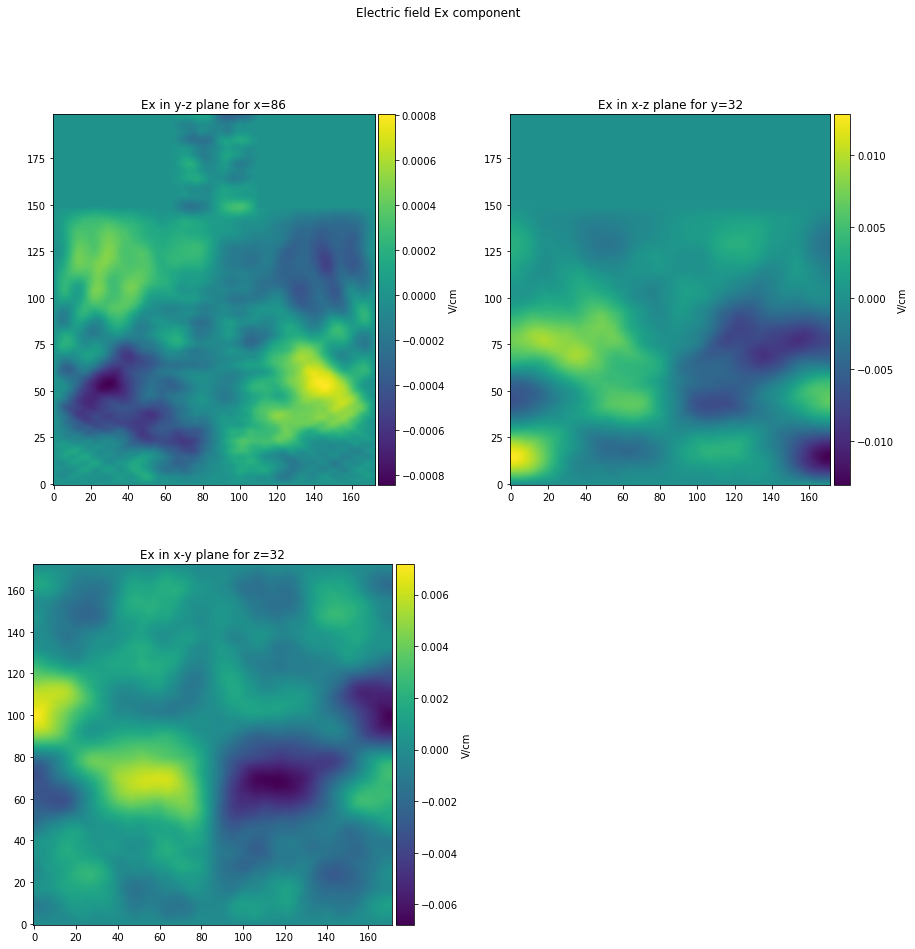

In [18]:
#constant planes in x,y,z
obj._fieldsEx(86,32,32)

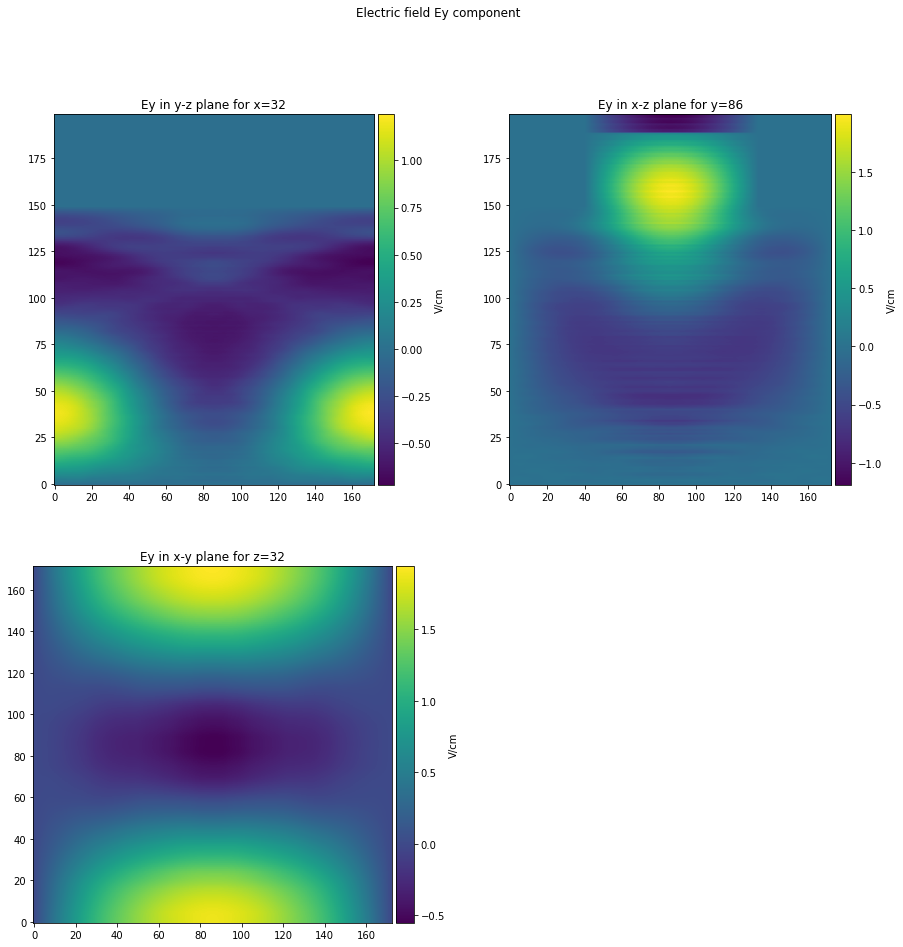

In [19]:
#constant planes in x,y,z
obj._fieldsEy(32,86,32)

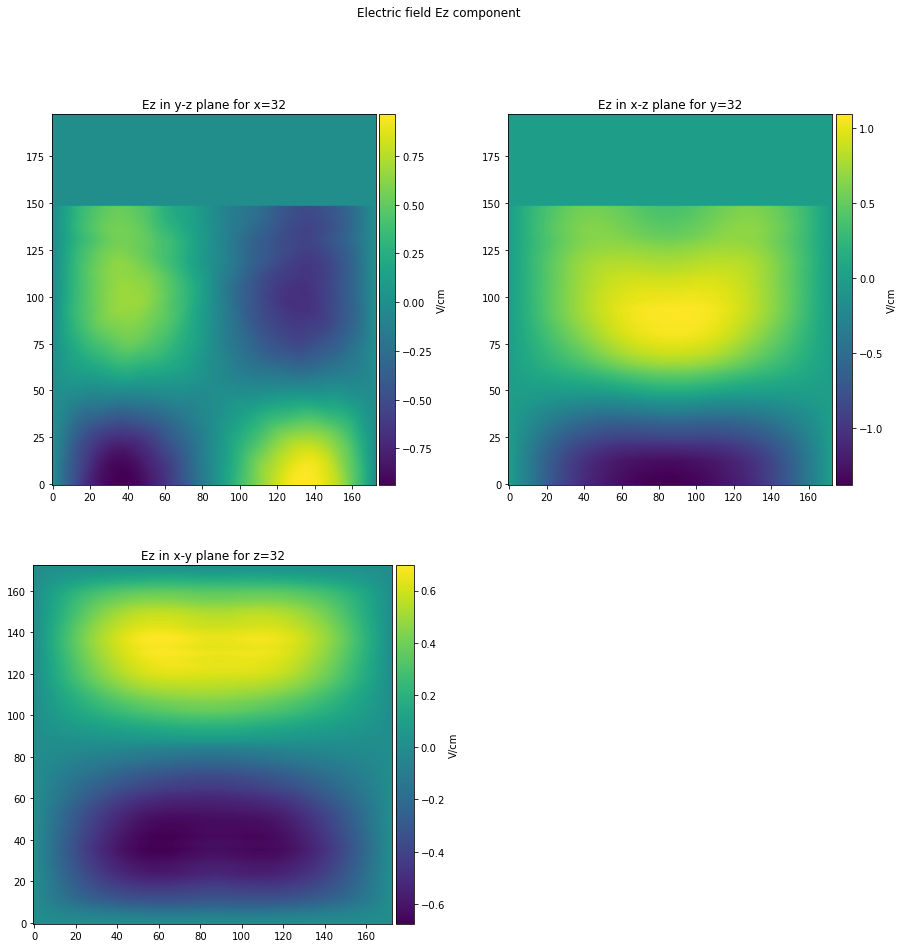

In [20]:
#constant planes in x,y,z
obj._fieldsEz(32,32,32)

### Now we put meat and potatoes in the oven

In [21]:
#list to keep SAR values
SAR=[]
obj.initiallize()

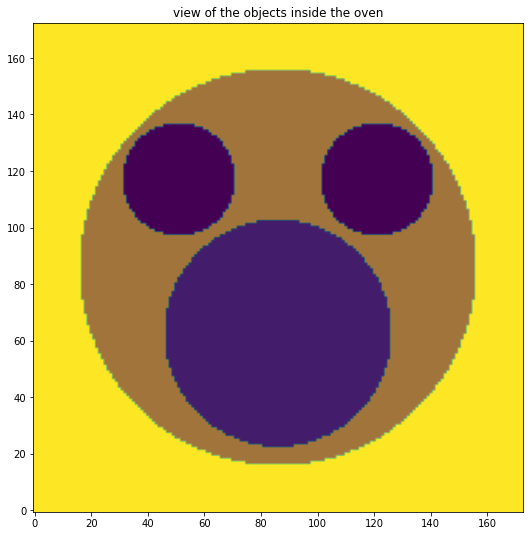

In [22]:
#create objects in the oven
obj.objects(3)  #number of objects
c,dx=obj.center_coor() #center of the oven and step dx
obj.add_object(c,[1,14],"plate") #add objects
obj.add_object([c[0],c[1]-14/6,2.2],[2,8],"meat")
obj.add_object([c[0]-14/4,c[1]+14/4-4*dx,1.1+dx+2],[2],"potato")
obj.add_object([c[0]+14/4,c[1]+14/4-4*dx,1.1+dx+2],[2],"potato")
obj._mat(30)

In [23]:
#run FDTD
obj.FDTD()

100%|██████████| 1121/1121 [14:19<00:00,  1.30it/s]


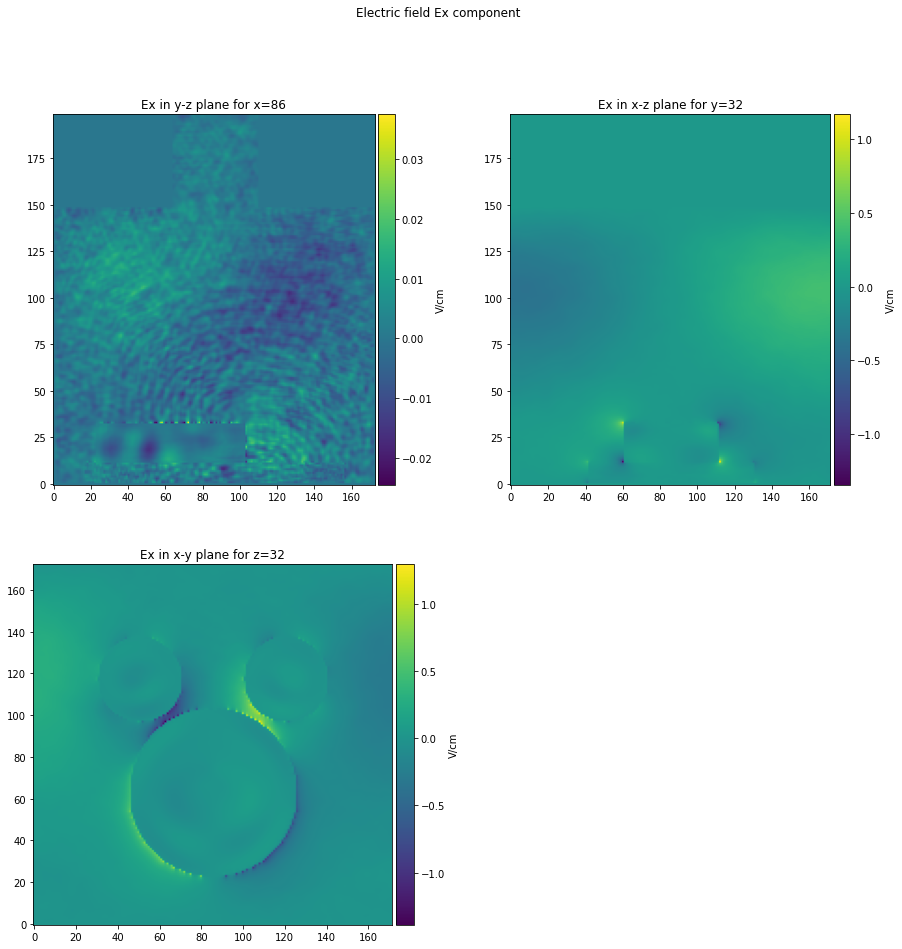

In [24]:
#constant planes in x,y,z
obj._fieldsEx(86,32,32)

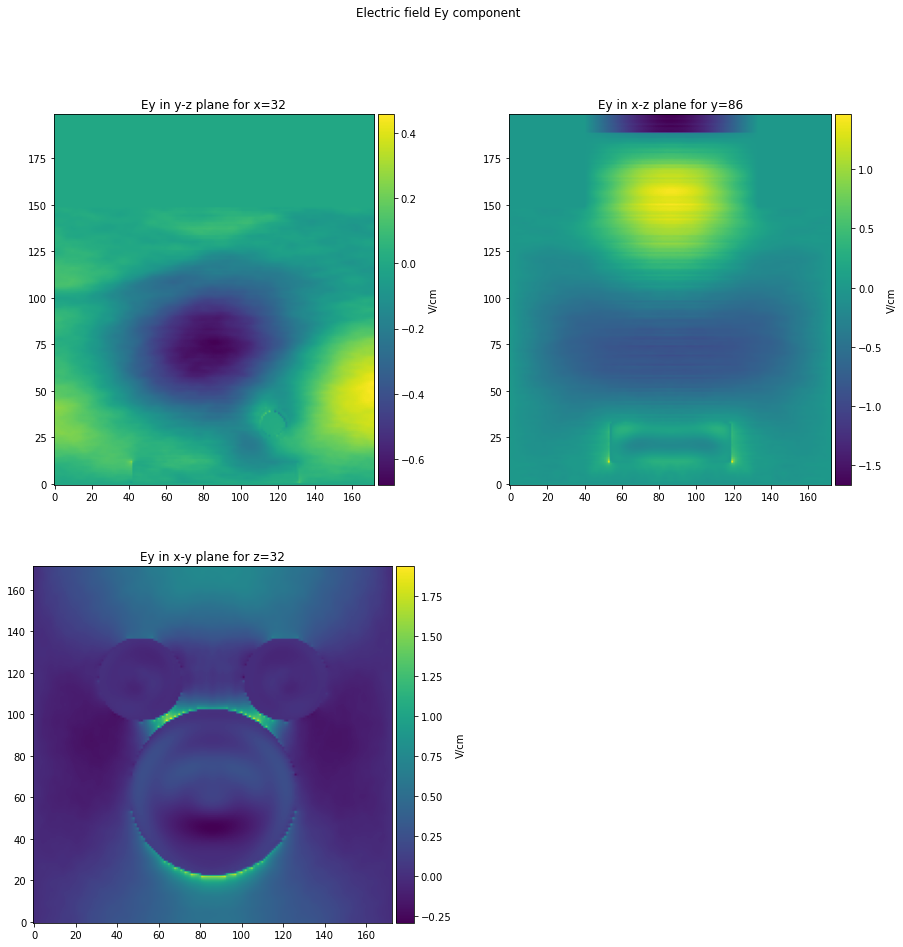

In [25]:
#constant planes in x,y,z
obj._fieldsEy(32,86,32)

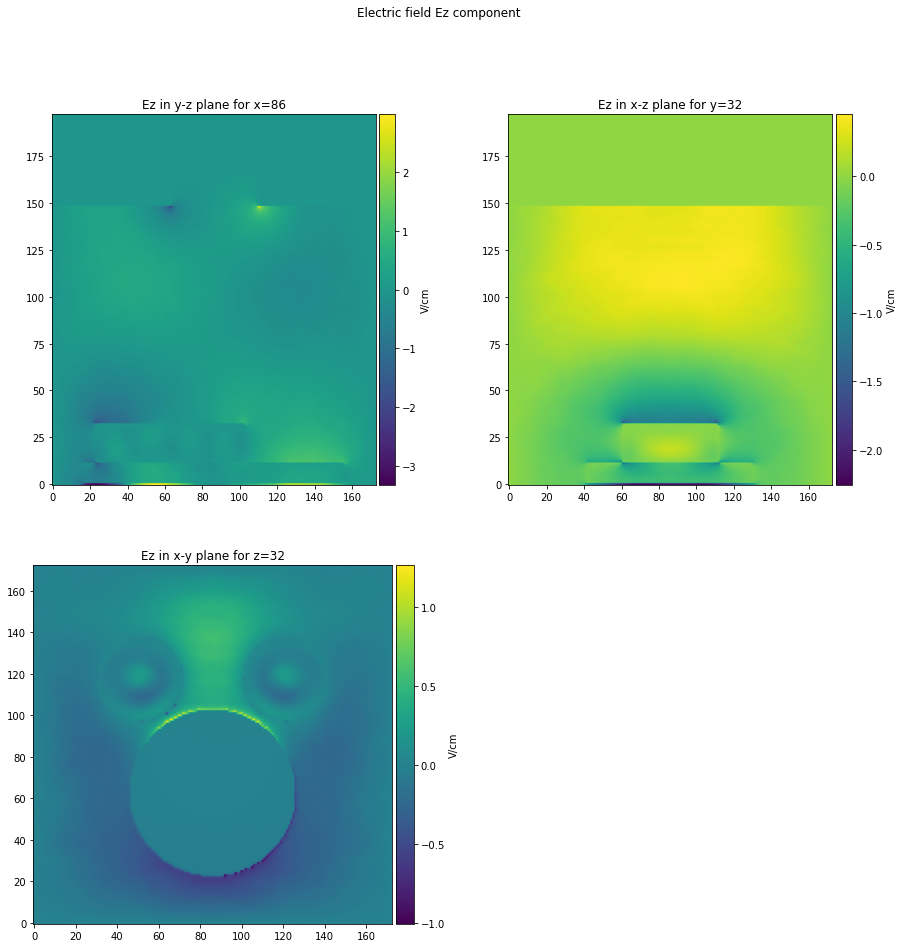

In [26]:
#constant planes in x,y,z
obj._fieldsEz(86,32,32)

In [27]:
#sar meat, pot1, pot2
SAR.append([obj._SAR(0,"meat",[2,8]),obj._SAR(1,"potato",[2]),obj._SAR(2,"potato",[2])])

Average SAR of meat  : 0.4156710956663727 W/kg
Average SAR of potato 1 : 0.1555899506041152 W/kg
Average SAR of potato 2 : 0.15382993201034617 W/kg


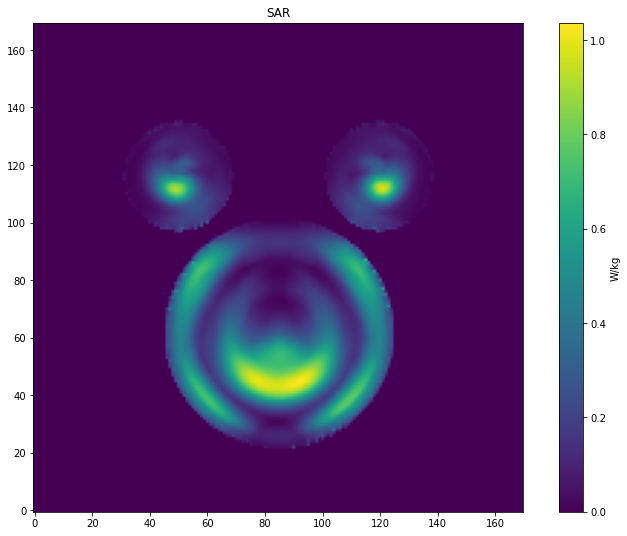

In [28]:
#SAR colormap choose constant number to take a cut with a given plane (0=x,1=y,2=z)
obj.print_SAR(25,2)

### Rotate initial plate by 90 degrees

In [29]:
#initiallize the grid
obj.initiallize()

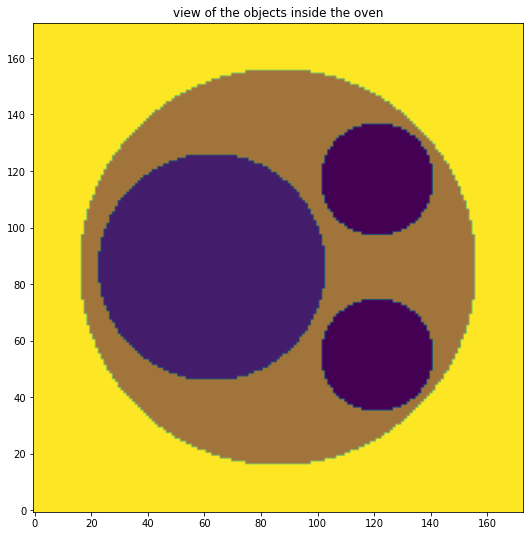

In [30]:
obj.objects(3)
c,dx=obj.center_coor()
obj.add_object(c,[1,14],"plate")
obj.add_object([c[0]-14/6,c[1],2.2],[2,8],"meat")
obj.add_object([c[0]+14/4,c[1]+14/4-4*dx,1.1+dx+2],[2],"potato")
obj.add_object([c[0]+14/4,c[1]-14/4+4*dx,1.1+dx+2],[2],"potato")
obj._mat(30)

In [31]:
#run FDTD
obj.FDTD()

100%|██████████| 1121/1121 [13:09<00:00,  1.42it/s]


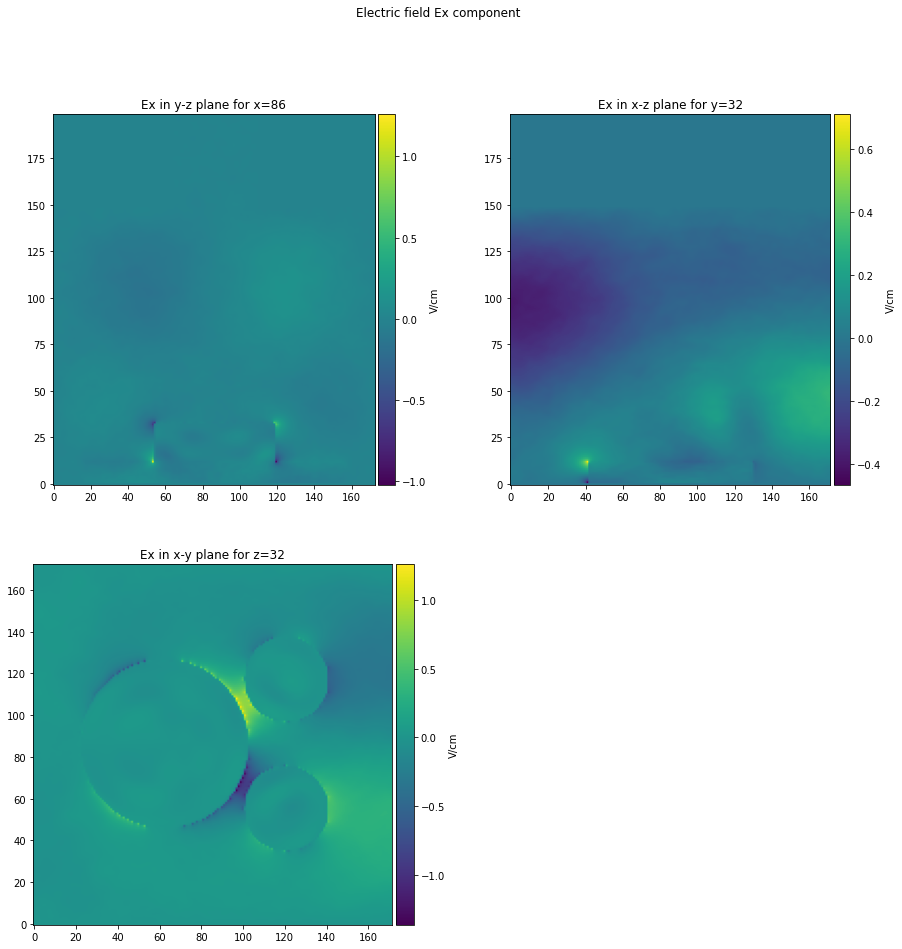

In [32]:
#constant planes in x,y,z
obj._fieldsEx(86,32,32)

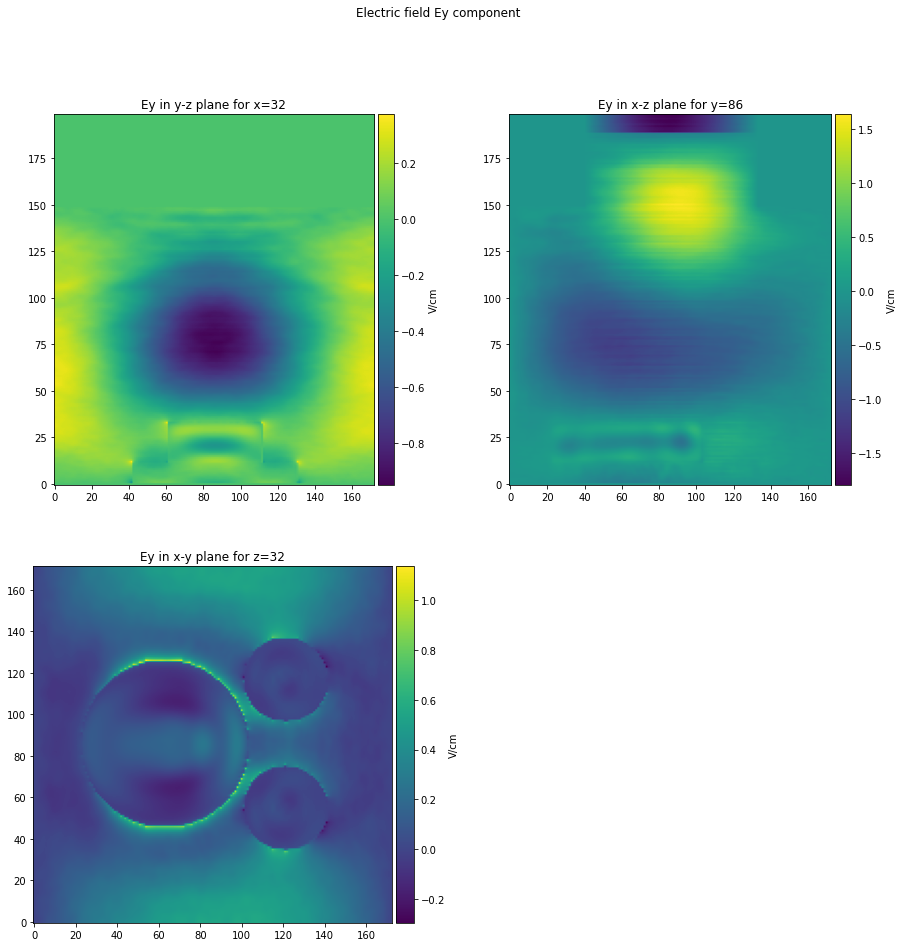

In [33]:
#constant planes in x,y,z
obj._fieldsEy(32,86,32)

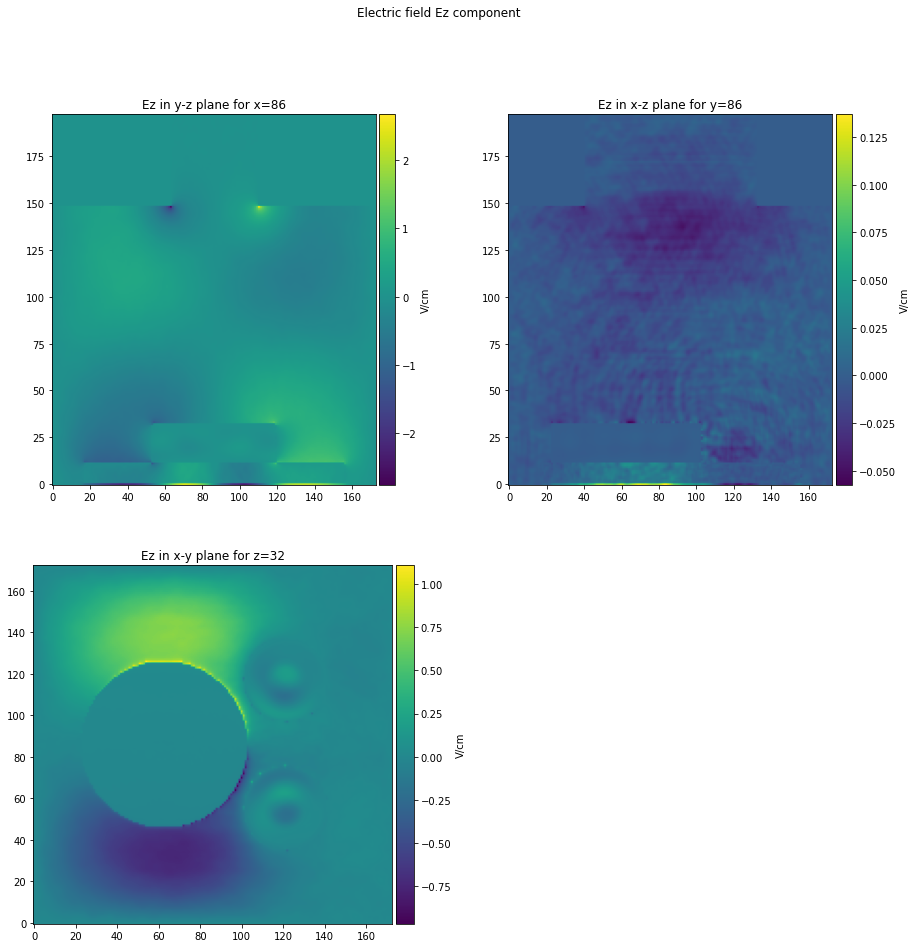

In [34]:
#constant planes in x,y,z
obj._fieldsEz(86,86,32)

In [35]:
#sar meat, pot1, pot2
SAR.append([obj._SAR(0,"meat",[2,8]),obj._SAR(1,"potato",[2]),obj._SAR(2,"potato",[2])])

Average SAR of meat  : 0.3604380664568323 W/kg
Average SAR of potato 1 : 0.14853501909261274 W/kg
Average SAR of potato 2 : 0.14997019940728457 W/kg


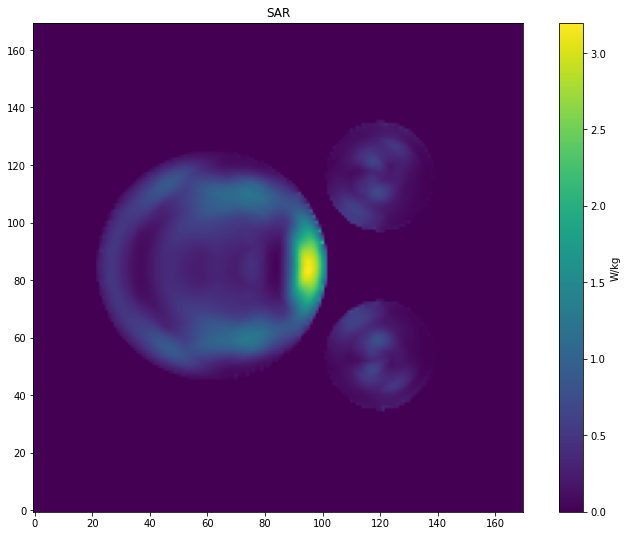

In [39]:
#SAR colormap choose constant number to take a cut with a given plane (0=x,1=y,2=z)
obj.print_SAR(25,2)

### Rotate initial plate by 180 degrees

In [47]:
#initiallize the grid
obj.initiallize()

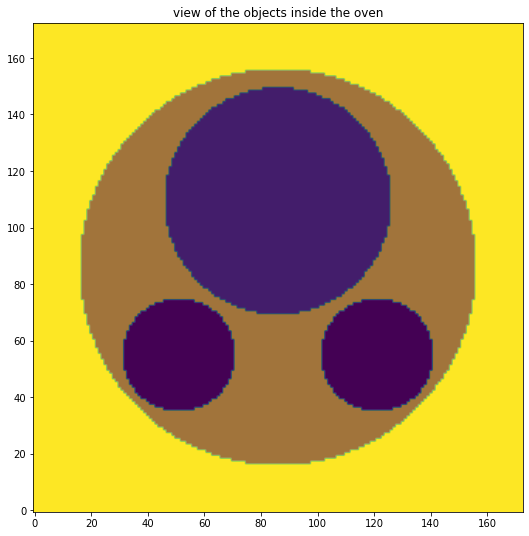

In [48]:
obj.objects(3)
c,dx=obj.center_coor()
obj.add_object(c,[1,14],"plate")
obj.add_object([c[0],c[1]+14/6,2.2],[2,8],"meat")
obj.add_object([c[0]+14/4,c[1]-14/4+4*dx,1.1+dx+2],[2],"potato")
obj.add_object([c[0]-14/4,c[1]-14/4+4*dx,1.1+dx+2],[2],"potato")
obj._mat(30)

In [49]:
#run FDTD
obj.FDTD()

100%|██████████| 1121/1121 [13:52<00:00,  1.35it/s]


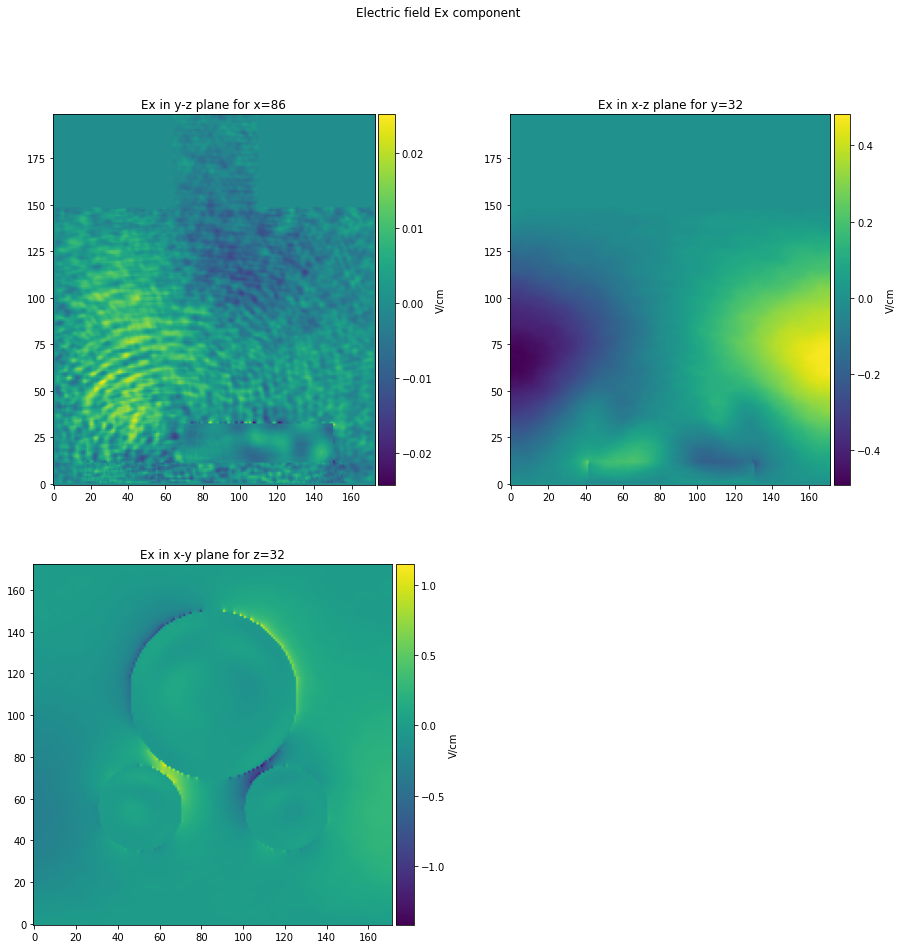

In [50]:
#constant planes in x,y,z
obj._fieldsEx(86,32,32)

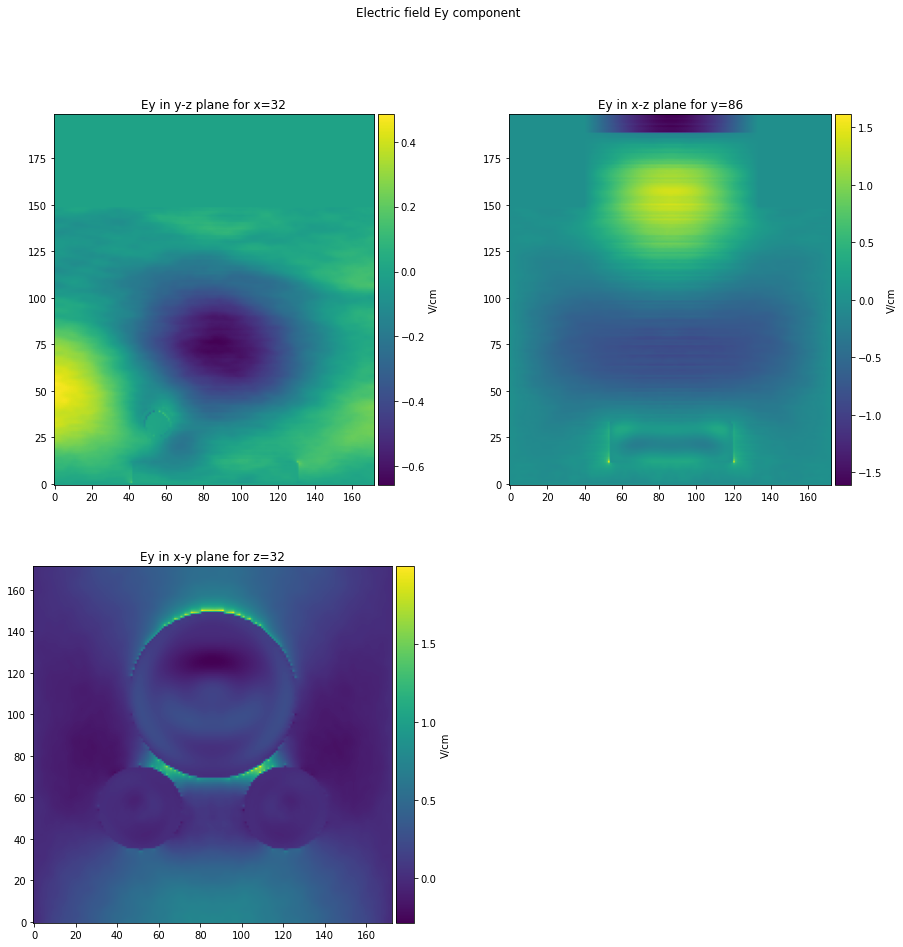

In [51]:
#constant planes in x,y,z
obj._fieldsEy(32,86,32)

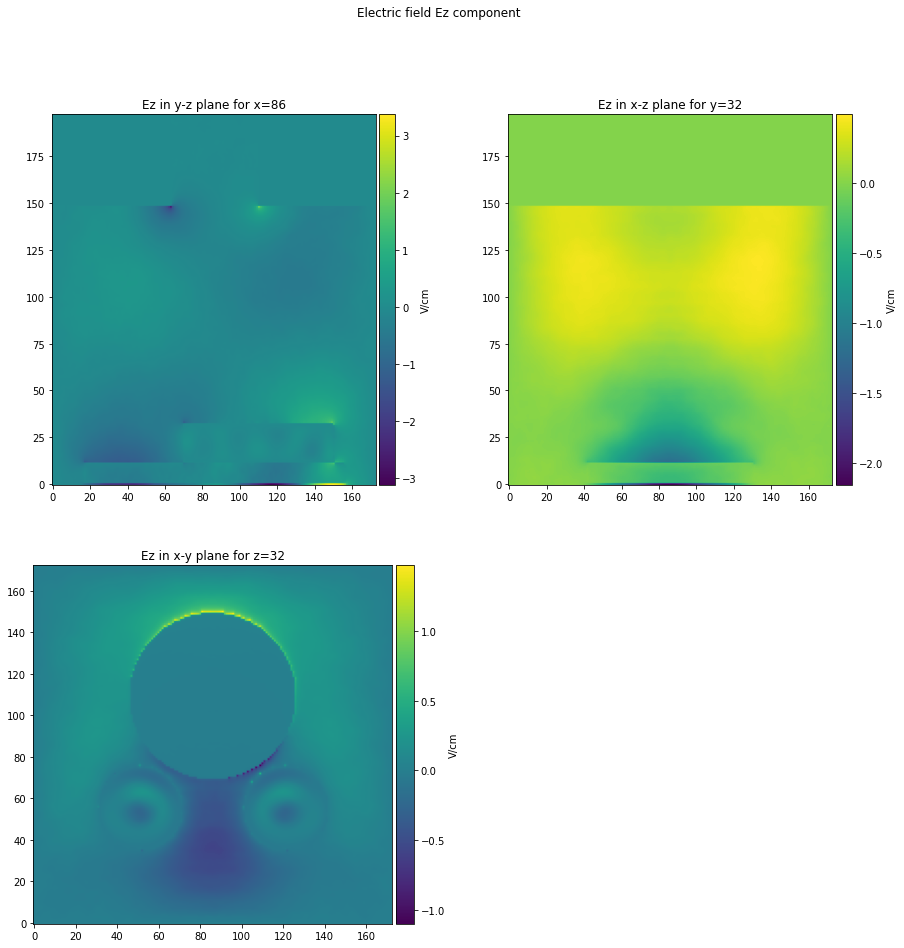

In [52]:
#constant planes in x,y,z
obj._fieldsEz(86,32,32)

In [53]:
#sar meat, pot1, pot2
SAR.append([obj._SAR(0,"meat",[2,8]),obj._SAR(1,"potato",[2]),obj._SAR(2,"potato",[2])])

Average SAR of meat  : 0.4235673620293281 W/kg
Average SAR of potato 1 : 0.15530963962055763 W/kg
Average SAR of potato 2 : 0.15720944348872187 W/kg


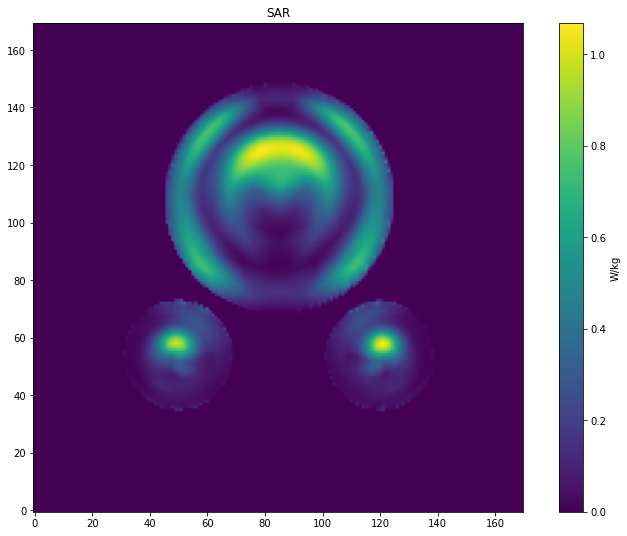

In [54]:
obj.print_SAR(25,2)

### Rotate initial plate by 270 degrees

In [56]:
#initiallize the grid
obj.initiallize()

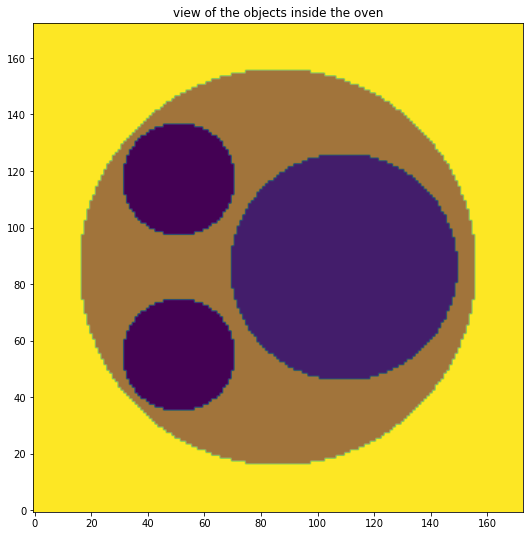

In [57]:
obj.objects(3)
c,dx=obj.center_coor()
obj.add_object(c,[1,14],"plate")
obj.add_object([c[0]+14/6,c[1],2.2],[2,8],"meat")
obj.add_object([c[0]-14/4,c[1]-14/4+4*dx,1.1+dx+2],[2],"potato")
obj.add_object([c[0]-14/4,c[1]+14/4-4*dx,1.1+dx+2],[2],"potato")
obj._mat(30)

In [58]:
#Run FDTD
obj.FDTD()

100%|██████████| 1121/1121 [14:33<00:00,  1.28it/s]


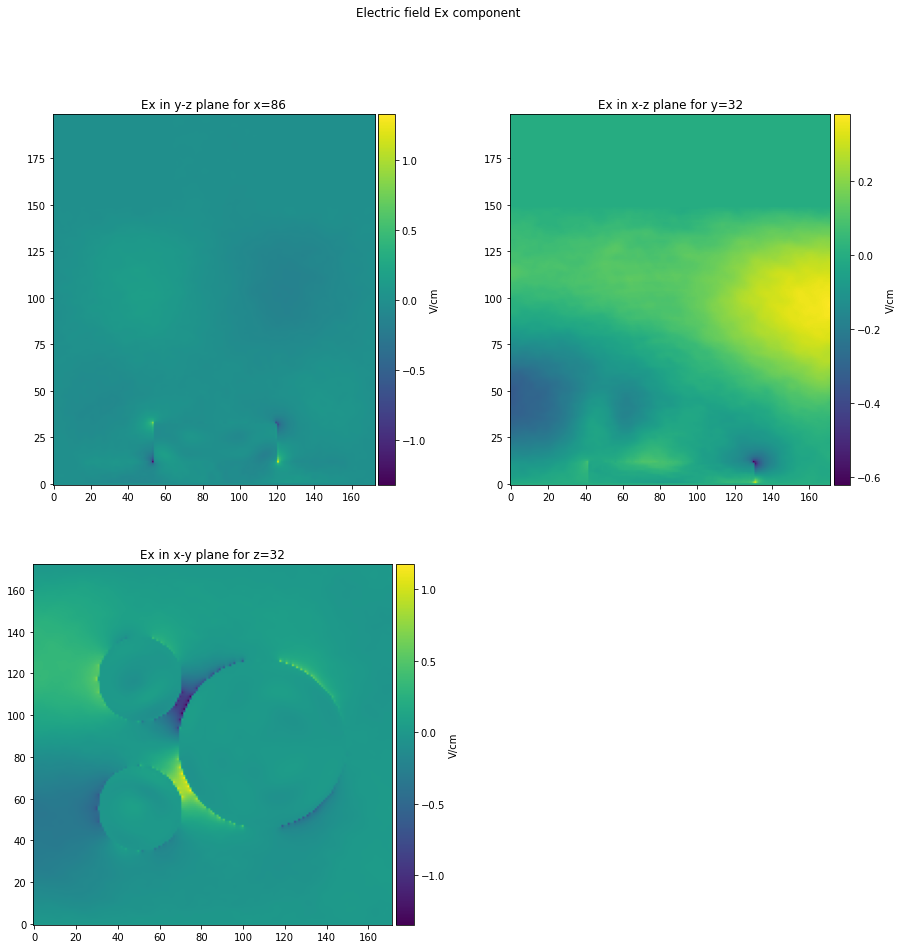

In [59]:
#constant planes in x,y,z
obj._fieldsEx(86,32,32)

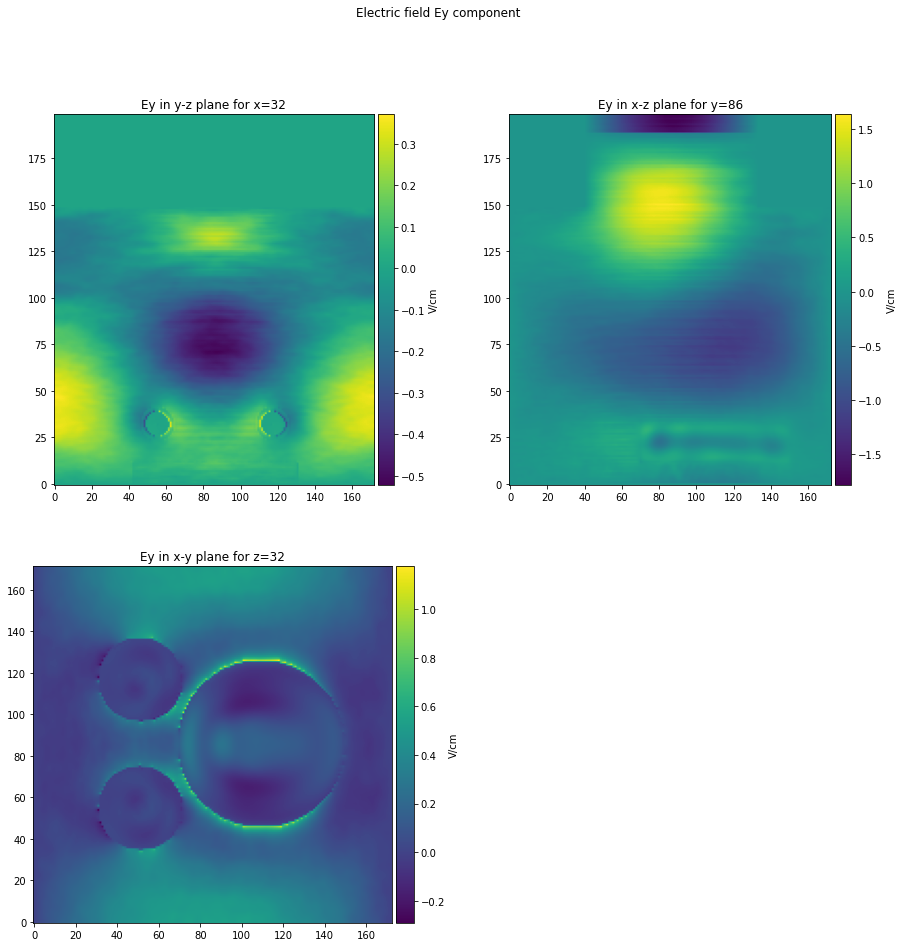

In [60]:
#constant planes in x,y,z
obj._fieldsEy(32,86,32)

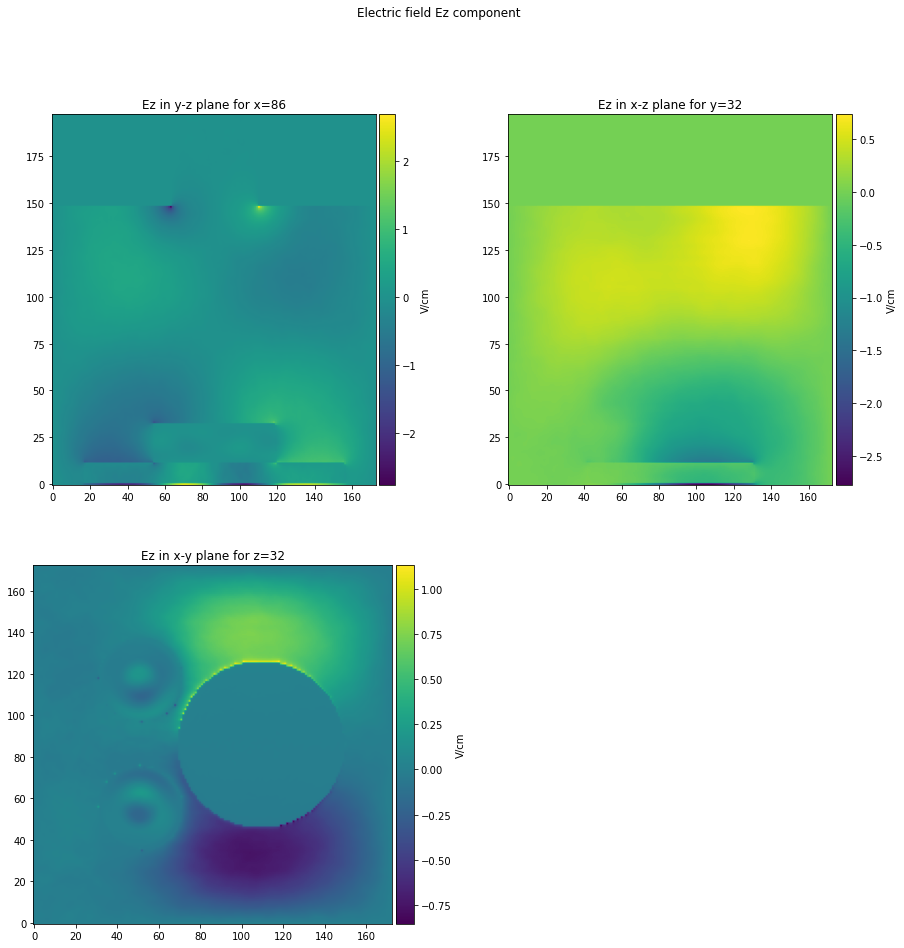

In [61]:
#constant planes in x,y,z
obj._fieldsEz(86,32,32)

In [62]:
#sar meat, pot1, pot2
SAR.append([obj._SAR(0,"meat",[2,8]),obj._SAR(1,"potato",[2]),obj._SAR(2,"potato",[2])])

Average SAR of meat  : 0.35941603926837096 W/kg
Average SAR of potato 1 : 0.15151798919992088 W/kg
Average SAR of potato 2 : 0.1519784204509039 W/kg


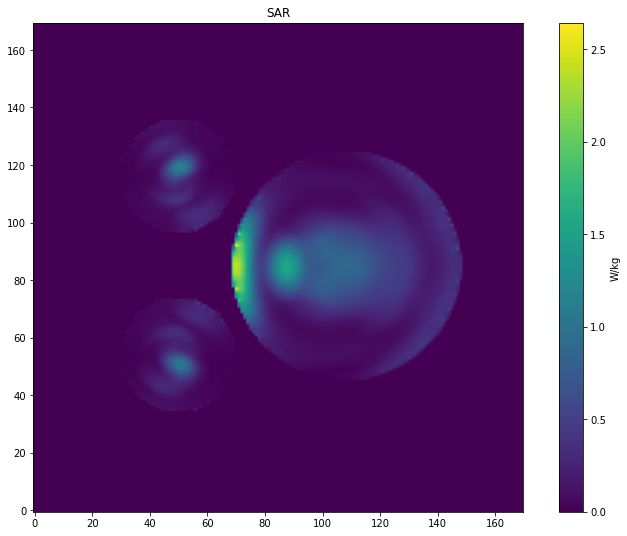

In [63]:
obj.print_SAR(30,2)

From the plane cuts of the SAR density for each angle we can see the non uniform SAR values inside the foods. The user can choose various plane cuts to and see the corresponding SAR density

### Calculation of mean SAR value and standard deviation for each object over the four confiqurations

In [64]:
#function to truncate float to specific decimals
def truncate(num, n):
    integer = int(num * (10**n))/(10**n)
    return float(integer)

In [65]:
#calculation of mean, std and Coefficient of variation
Means=np.mean(SAR,0)
stds=np.std(SAR,0)
CV=(stds/Means)*100
print("Mean and std values of SAR averaged over the for configurations")
print("Meat: mean=",Means[0],"W/kg","std=",stds[0],"W/kg","CV=",CV[0],"%")
print("Potato 1: mean=",Means[1],"W/kg","std=",stds[1],"W/kg","CV=",CV[1],"%")
print("Potato 2: mean=",Means[2],"W/kg","std=",stds[2],"W/kg","CV=",CV[2],"%")

Mean and std values of SAR averaged over the for configurations
Meat: mean= 0.389773140855226 W/kg std= 0.029978549226397942 W/kg CV= 7.691281436329887 %
Potato 1: mean= 0.15273814962930163 W/kg std= 0.002911203675327042 W/kg CV= 1.9060095217812891 %
Potato 2: mean= 0.15324699883931414 W/kg std= 0.0026639953231378005 W/kg CV= 1.738367043605931 %


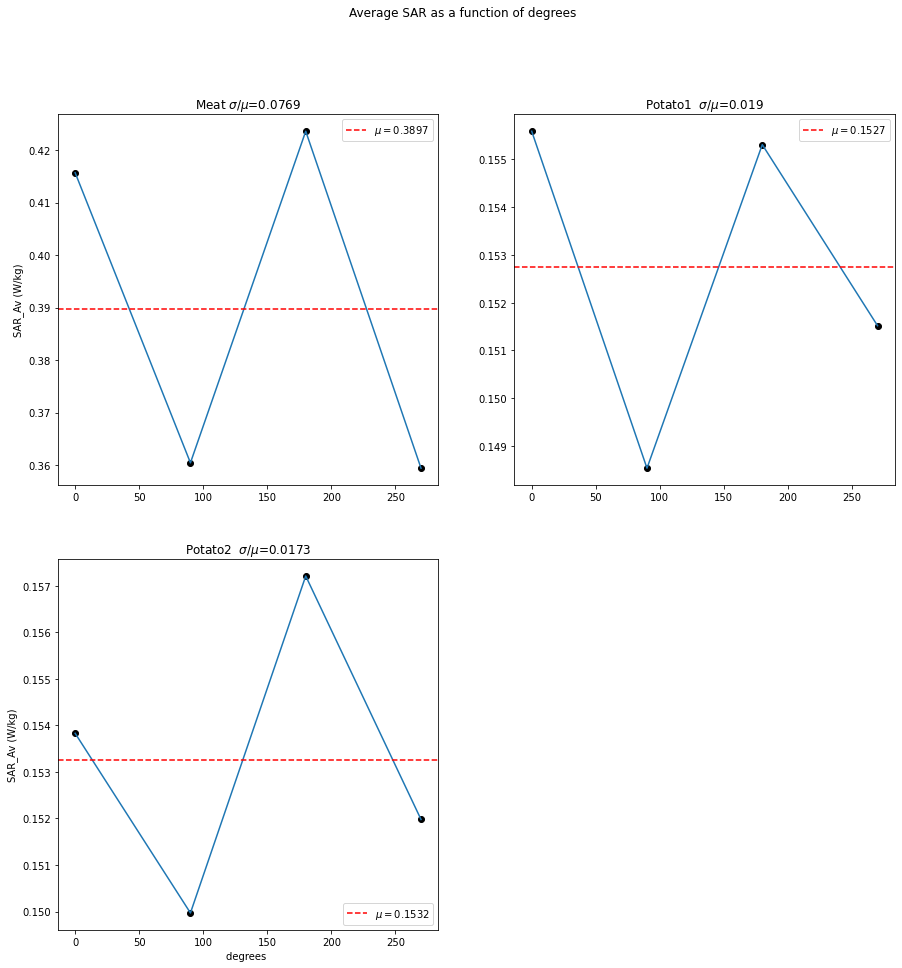

In [66]:
#plots of Average SAR-degrees
deg=[0,90,180,270]
Meat=[SAR[0][0],SAR[1][0],SAR[2][0],SAR[3][0]]
Potato1=[SAR[0][1],SAR[1][1],SAR[2][1],SAR[3][1]]
Potato2=[SAR[0][2],SAR[1][2],SAR[2][2],SAR[3][2]]
fig, axs = plt.subplots(2, 2,figsize=(15,15))
fig.suptitle('Average SAR as a function of degrees')
axs[0,0].scatter(deg,Meat,c="black")
axs[0,0].plot(deg,Meat)
axs[0,0].axhline(y=Means[0], color='r', linestyle='dashed',label="$\mu=$"+str(truncate(Means[0],4)))
axs[0,0].legend(loc="upper right")
axs[0,0].set_title("Meat $\sigma/\mu$="+str(truncate(CV[0]/100,4)))
axs[0,1].scatter(deg,Potato1,c="black")
axs[0,1].plot(deg,Potato1)
axs[0,1].axhline(y=Means[1], color='r', linestyle='dashed',label="$\mu=$"+str(truncate(Means[1],4)))
axs[0,1].legend(loc="upper right")
axs[0,1].set_title("Potato1  $\sigma/\mu$="+str(truncate(CV[1]/100,4)))
axs[1,0].scatter(deg,Potato2,c="black")
axs[1,0].plot(deg,Potato2)
axs[1,0].axhline(y=Means[2], color='r', linestyle='dashed',label="$\mu=$"+str(truncate(Means[2],4)))
axs[1,0].legend(loc="lower right")
axs[1,0].set_title("Potato2  $\sigma/\mu$="+str(truncate(CV[2]/100,4)))
axs[1,1].axis("off")
plt.setp(axs[-1, :], xlabel='degrees ')
plt.setp(axs[:, 0], ylabel='SAR_Av (W/kg)')
plt.show()

#### The results are summarized in the following table

|Object | Avg SAR ($0^{o}$)(W/kg)| Avg SAR ($90^{o}$)(W/kg)| Avg SAR ($180^{o}$)(W/kg)|Avg SAR ($270^{o}$)(W/kg) | $\mu_{conf}$ (W/kg)|$\sigma$ (W/kg)|$\sigma$/$\mu_{conf}$ (%)|
|----------:|:------|:-----|:-----|:-----|:-----|:---|:----|
| Meat      |0.4156 |0.3604|0.4235|0.3594|0.3897|0.0299|7.69%|
| Potato 1  |0.1555 |0.1485|0.1553|0.1515|0.1527|0.0029|1.90%|
| Potato 2  |0.1538 |0.1499|0.1572|0.1519|0.1532|0.0026|1.73%|


where $\mu_{conf}$ is the average over the four configurations and $\sigma/\mu_{conf}$ is the coefficient of variation that we will use it to check uniform heating.

We see that for the two potatoes the standard deviation is smaller than the meat. This has to do with the position and the dimensions of the waveguide that we took in our model. When the meat is almost below the waveguide the average SAR is greater which is reasonable. So in general we can say that we have uniform heating by looking the coefficient of variation $\sigma/\mu$.